## On essaye de calculer les forces de pression autour du cylindre 

In [1]:
from animate import anim 
import numpy as np
import torch 
from model import PINNs
from deepxrte.geometry import Rectangle
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt

In [46]:
# On importe le modèle entrainé

with open("results/1_first_try" + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)

model = PINNs(hyper_param)
checkpoint = torch.load('results/1_first_try/epoch1700'+'/model_weights.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])


/tmp/ipykernel_11861/1971519048.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('results/1_first_try/epoch1700'+'/model_weights.pth', map_locatio

<All keys matched successfully>

In [21]:
param_adim = {
    'V':2,
    'L':0.025,
    'rho': 1.2
}

In [5]:
X_train, U_train, X_full, U_full, X_border,X_border_test, mean_std = charge_data(hyper_param, param_adim)
X_pred = torch.tensor(X_full, dtype=torch.float32)
U_pred = model(X_pred)
x_norm_pred, y_norm_pred, t_norm_pred = X_pred.detach().numpy()[:,0], X_pred.detach().numpy()[:,1], X_pred.detach().numpy()[:,2]
u_norm_pred, v_norm_pred, p_norm_pred = U_pred.detach().numpy()[:,0], U_pred.detach().numpy()[:,1], U_pred.detach().numpy()[:,2]


On a pour la force de portance : 

$
\overrightarrow{F_p}=-\int_{\theta=0}^{2\pi}(P(\theta)sin(\theta)rd\theta) \overrightarrow{u_y}
$


Pour la force de trainé :

$
\overrightarrow{F_t}=-\int_{\theta=0}^{2\pi}(P(\theta)cos(\theta)rd\theta) \overrightarrow{u_y}
$

In [47]:
# Calcul avec une intégration numérique : 
r = 0.025/2

def P(theta, t):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    x_ad = ((x / param_adim['L']) - mean_std['x_mean'])/mean_std['x_std']
    y_ad = ((y / param_adim['L']) - mean_std['y_mean'])/mean_std['y_std']
    t_ad = ((t / (param_adim['L'] / param_adim['V'])) - mean_std['t_mean'])/mean_std['t_std']
    P_adim = model(torch.tensor([x_ad, y_ad, t_ad], dtype=torch.float32))[2]
    P = ((P_adim * mean_std['p_std'] + mean_std['p_mean']))*((param_adim['V']**2)*param_adim['rho'])
    return P.detach().item()
    

In [48]:
# Donne la pression mais dans une unité bizarre (des bar ?)

In [49]:
P(theta=3.14, t=0)

1.097636342048645

In [50]:
def force_portance(t, N_points=1000):
    """Calcul la force de portance au temps t"""
    d_theta = 2 * np.pi / N_points
    sum_integrale = 0
    for theta in np.linspace(0, 2*np.pi, N_points):
        sum_integrale += - P(theta, t)*np.sin(theta)*r*d_theta
    return sum_integrale

def force_traine(t, N_points=1000):
    """Calcul la force de portance au temps t"""
    d_theta = 2 * np.pi / N_points
    sum_integrale = 0
    for theta in np.linspace(0, 2*np.pi, N_points):
        sum_integrale += - P(theta, t)*np.cos(theta)*r*d_theta
    return sum_integrale

In [51]:
time = np.linspace(7.6, 7.8, 100)

In [52]:
portance = np.array([force_portance(t) for t in time])

In [53]:
traine = np.array([force_traine(t) for t in time])

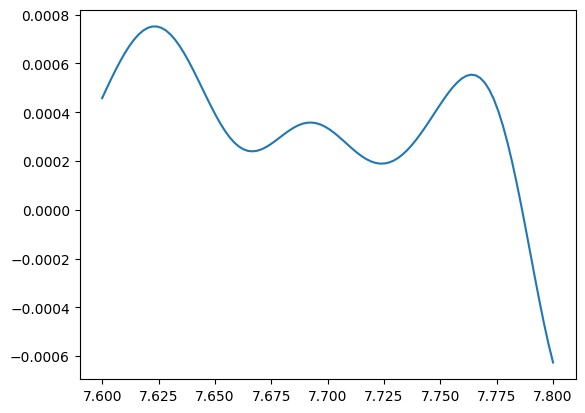

In [54]:
plt.plot(time, portance)

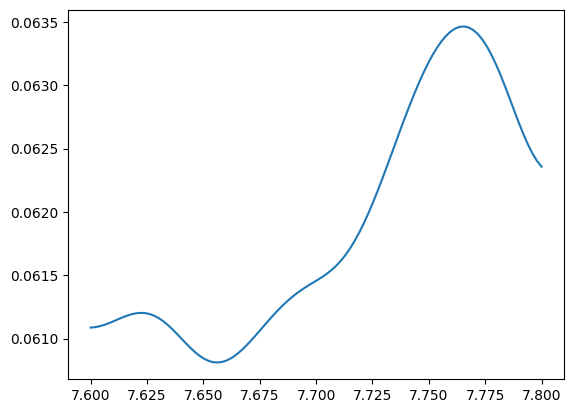

In [55]:
plt.plot(time, traine)